# **Building Music Recommendation System using Spotify Dataset**


Hello and welcome to my kernel. In this kernel, I have created Music Recommendation System using Spotify Dataset. To do this, I presented some of the visualization processes to understand data and done some EDA(Exploratory Data Analysis) so we can select features that are relevant to create a Recommendation System.

# **Import Libraries**

In [ ]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")

# **Read Data**

In [ ]:
data = pd.read_csv("/content/data.csv")
genre_data = pd.read_csv('/content/data_by_genres.csv')
year_data = pd.read_csv('/content/data_by_year.csv')

In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [ ]:
print(genre_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2973 entries, 0 to 2972
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              2973 non-null   int64  
 1   genres            2973 non-null   object 
 2   acousticness      2973 non-null   float64
 3   danceability      2973 non-null   float64
 4   duration_ms       2973 non-null   float64
 5   energy            2973 non-null   float64
 6   instrumentalness  2973 non-null   float64
 7   liveness          2973 non-null   float64
 8   loudness          2973 non-null   float64
 9   speechiness       2973 non-null   float64
 10  tempo             2973 non-null   float64
 11  valence           2973 non-null   float64
 12  popularity        2973 non-null   float64
 13  key               2973 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 325.3+ KB
None


In [ ]:
print(year_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              100 non-null    int64  
 1   year              100 non-null    int64  
 2   acousticness      100 non-null    float64
 3   danceability      100 non-null    float64
 4   duration_ms       100 non-null    float64
 5   energy            100 non-null    float64
 6   instrumentalness  100 non-null    float64
 7   liveness          100 non-null    float64
 8   loudness          100 non-null    float64
 9   speechiness       100 non-null    float64
 10  tempo             100 non-null    float64
 11  valence           100 non-null    float64
 12  popularity        100 non-null    float64
 13  key               100 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 11.1 KB
None


We are going to check for all the analysis with the target as **'popularity'**. Before going to do that let's check for the Feature Correlation by considering a few features and for that, I'm going to use the **yellowbrick** package. You can learn more about it from the [documentation](https://www.scikit-yb.org/en/latest/index.html).

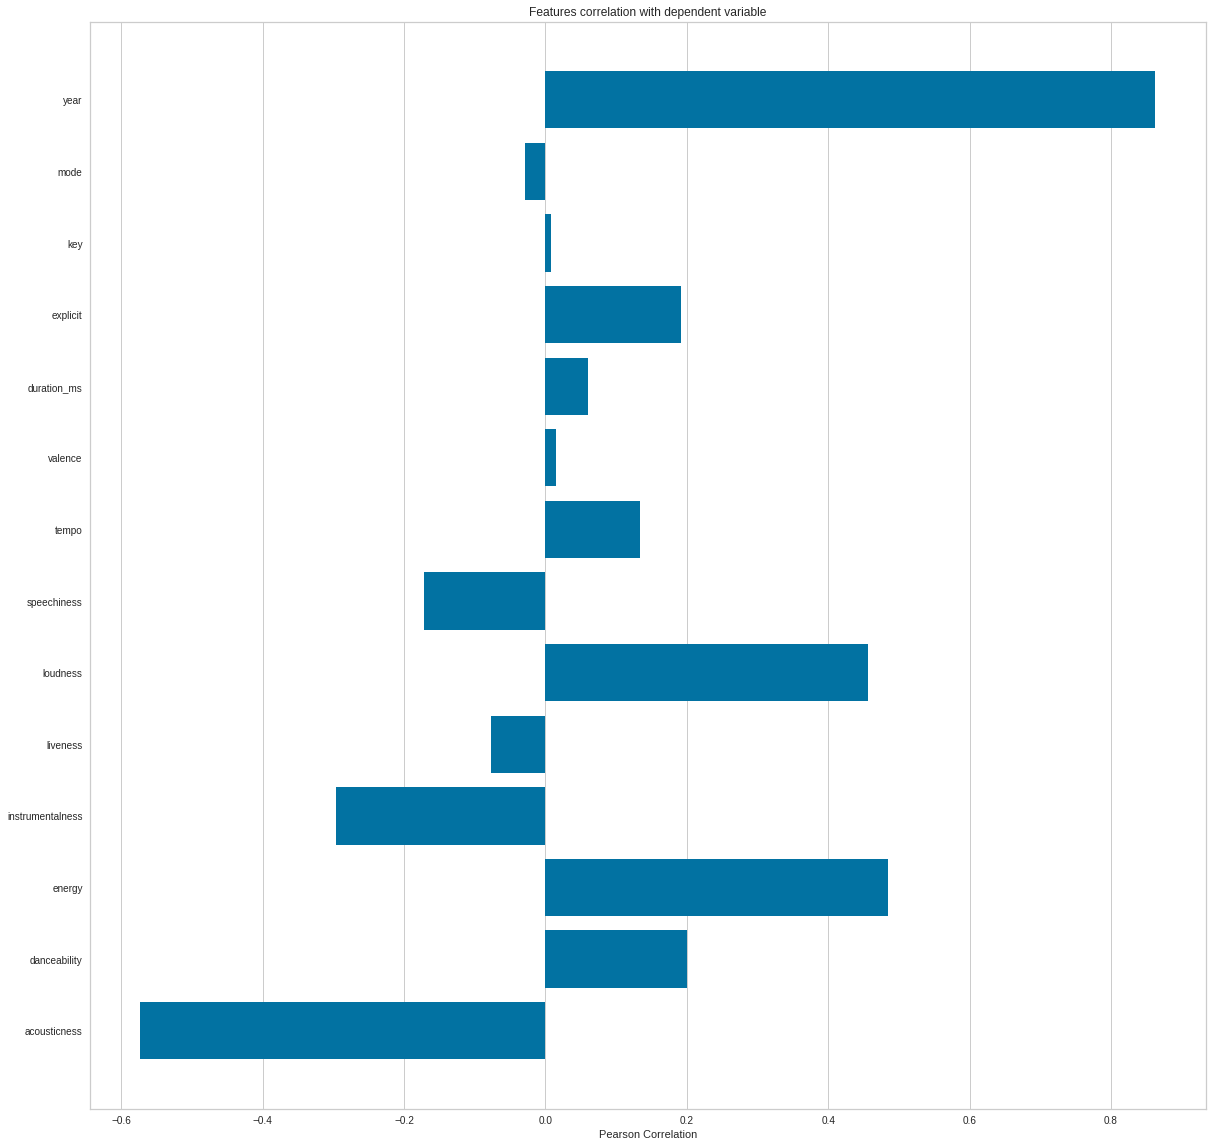

In [ ]:
from yellowbrick.target import FeatureCorrelation

feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms','explicit','key','mode','year']

X, y = data[feature_names], data['popularity']

# Create a list of the feature names
features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(20,20)
visualizer.fit(X, y)     # Fit the data to the visualizer
visualizer.show()

# **Data Understanding by Visualization and EDA**

# **Music Over Time**

Using the data grouped by year, we can understand how the overall sound of music has changed from 1921 to 2020.

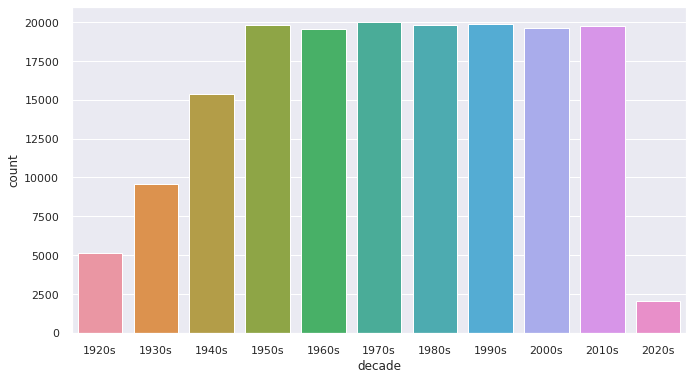

In [ ]:
def get_decade(year):
    period_start = int(year/10) * 10
    decade = '{}s'.format(period_start)
    return decade

data['decade'] = data['year'].apply(get_decade)

sns.set(rc={'figure.figsize':(11 ,6)})
sns.countplot(data['decade'])

In [ ]:
sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence']
fig = px.line(year_data, x='year', y=sound_features)
fig.show()

# **Characteristics of Different Genres**

This dataset contains the audio features for different songs along with the audio features for different genres. We can use this information to compare different genres and understand their unique differences in sound.

In [ ]:
top10_genres = genre_data.nlargest(10, 'popularity')

fig = px.bar(top10_genres, x='genres', y=['valence', 'energy', 'danceability', 'acousticness'], barmode='group')
fig.show()

# **Clustering Genres with K-Means**

Here, the simple K-means clustering algorithm is used to divide the genres in this dataset into ten clusters based on the numerical audio features of each genres.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=10))])
X = genre_data.select_dtypes(np.number)
cluster_pipeline.fit(X)
genre_data['cluster'] = cluster_pipeline.predict(X)

In [ ]:
# Visualizing the Clusters with t-SNE

from sklearn.manifold import TSNE

tsne_pipeline = Pipeline([('scaler', StandardScaler()), ('tsne', TSNE(n_components=2, verbose=1))])
genre_embedding = tsne_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
projection['genres'] = genre_data['genres']
projection['cluster'] = genre_data['cluster']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'genres'])
fig.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2973 samples in 0.005s...
[t-SNE] Computed neighbors for 2973 samples in 0.289s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2973
[t-SNE] Computed conditional probabilities for sample 2000 / 2973
[t-SNE] Computed conditional probabilities for sample 2973 / 2973
[t-SNE] Mean sigma: 0.777516
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.113426
[t-SNE] KL divergence after 1000 iterations: 1.389343


# **Clustering Songs with K-Means**

In [ ]:
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                                  ('kmeans', KMeans(n_clusters=20, 
                                   verbose=False))
                                 ], verbose=False)

X = data.select_dtypes(np.number)
number_cols = list(X.columns)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
data['cluster_label'] = song_cluster_labels

In [ ]:
# Visualizing the Clusters with PCA

from sklearn.decomposition import PCA

pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = data['name']
projection['cluster'] = data['cluster_label']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title'])
fig.show()

# **Build Recommender System**

* Based on the analysis and visualizations, it’s clear that similar genres tend to have data points that are located close to each other while similar types of songs are also clustered together.
* This observation makes perfect sense. Similar genres will sound similar and will come from similar time periods while the same can be said for songs within those genres. We can use this idea to build a recommendation system by taking the data points of the songs a user has listened to and recommending songs corresponding to nearby data points.
* [Spotipy](https://spotipy.readthedocs.io/en/2.16.1/) is a Python client for the Spotify Web API that makes it easy for developers to fetch data and query Spotify’s catalog for songs. You have to install using `pip install spotipy`
* After installing Spotipy, you will need to create an app on the [Spotify Developer’s page](https://developer.spotify.com/) and save your Client ID and secret key.

In [ ]:
!pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict
import pickle

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="71497b4220624f5b878b6b464df4238e", client_secret="4738a404774c4775a181429156210862"))

def find_song(name, year):
    song_data = defaultdict()
    results = sp.search(q= 'track: {} year: {}'.format(name,year), limit=1)
    if results['tracks']['items'] == []:
        return None

    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]

    song_data['name'] = [name]
    song_data['year'] = [year]
    song_data['explicit'] = [int(results['explicit'])]
    song_data['duration_ms'] = [results['duration_ms']]
    song_data['popularity'] = [results['popularity']]

    for key, value in audio_features.items():
        song_data[key] = value
    pickle.dump(song_data,open("model.pkl","wb"))
    return pd.DataFrame(song_data)

In [ ]:
from collections import defaultdict
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
import difflib

number_cols = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']


def get_song_data(song, spotify_data):
    
    try:
        song_data = spotify_data[(spotify_data['name'] == song['name']) 
                                & (spotify_data['year'] == song['year'])].iloc[0]
        return song_data
    
    except IndexError:
        return find_song(song['name'], song['year'])
        

def get_mean_vector(song_list, spotify_data):
    
    song_vectors = []
    
    for song in song_list:
        song_data = get_song_data(song, spotify_data)
        if song_data is None:
            print('Warning: {} does not exist in Spotify or in database'.format(song['name']))
            continue
        song_vector = song_data[number_cols].values
        song_vectors.append(song_vector)  
    
    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)


def flatten_dict_list(dict_list):
    
    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []
    
    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)
            
    return flattened_dict


def recommend_songs( song_list, spotify_data, n_songs=10):
    
    metadata_cols = ['name', 'year', 'artists']
    song_dict = flatten_dict_list(song_list)
    
    song_center = get_mean_vector(song_list, spotify_data)
    scaler = song_cluster_pipeline.steps[0][1]
    scaled_data = scaler.transform(spotify_data[number_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])
    
    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[metadata_cols[0]]

In [ ]:
recommend_songs([{'name': 'Boy With Luv (feat. Halsey)', 'year':2019},
                {'name': 'BOOMBAYAH', 'year': 2016},
                {'name': 'Lovesick Girls', 'year': 2020},
                {'name': 'All Apologies', 'year': 1993},
                {'name': 'Stay Away', 'year': 1993}],  data)

18683                                         Parachute
37520                           Adventure of a Lifetime
19013                            When It Rains It Pours
74976    Thunderclouds (feat. Sia, Diplo, and Labrinth)
57168                                         La Da Dee
19534                                     Make You Mine
74169                                 I Really Like You
19784                   Rain On Me (with Ariana Grande)
74926                     Body Back (feat. Maia Wright)
57220                   Rain On Me (with Ariana Grande)
Name: name, dtype: object

* This last cell will gives you a recommendation list of songs like this,


```
[{'name': 'Life is a Highway - From "Cars"',
  'year': 2009,
  'artists': "['Rascal Flatts']"},
 {'name': 'Of Wolf And Man', 'year': 1991, 'artists': "['Metallica']"},
 {'name': 'Somebody Like You', 'year': 2002, 'artists': "['Keith Urban']"},
 {'name': 'Kayleigh', 'year': 1992, 'artists': "['Marillion']"},
 {'name': 'Little Secrets', 'year': 2009, 'artists': "['Passion Pit']"},
 {'name': 'No Excuses', 'year': 1994, 'artists': "['Alice In Chains']"},
 {'name': 'Corazón Mágico', 'year': 1995, 'artists': "['Los Fugitivos']"},
 {'name': 'If Today Was Your Last Day',
  'year': 2008,
  'artists': "['Nickelback']"},
 {'name': "Let's Get Rocked", 'year': 1992, 'artists': "['Def Leppard']"},
 {'name': "Breakfast At Tiffany's",
  'year': 1995,
  'artists': "['Deep Blue Something']"}]
```



* You can change the given songs list as per your choice.